In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CP483_Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports for data manipulation, processing, and visuals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import joblib
import pickle

In [ ]:
# Read the processed data file
data = pd.read_csv('BitcoinHeistDataPREPROCESSED.csv')
data_length = len(data)

In [ ]:
# Save the feature and label labels for ease of use when graphing
feature_labels = ['length', 'weight', 'count', 'looped', 'neighbors', 'income',
                  'log_income']
target_label = ['label']

In [ ]:
#-------------------------------------------------------------------------------
# Feature Engineering (Required for properly functioning models)
#-------------------------------------------------------------------------------

# Make an engineered data frame to add engineered data to
engineered_data = data.copy()

# Log scale eighbors to reduce skewness
engineered_data['log_count'] = np.log1p(data['count'])

# Log scale eighbors to reduce skewness
engineered_data['log_weight'] = np.log1p(data['weight'])

# Log scale eighbors to reduce skewness
engineered_data['log_income'] = np.log1p(data['income'])

# Normalizes income by transaction volume
engineered_data['income_per_trx'] = data['income'] / data['count']

# Merging intensity per transaction
engineered_data['merge_ratio']= data['weight'] / data['count']

# Fraction of looped transactions
engineered_data['looped_ratio'] = data['looped'] / data['count']

# Binary flag for any looping
engineered_data['is_looped'] = (data['looped'] > 0).astype(int)

# Flag large payments (common in ransomware)
engineered_data['high_income'] = (data['income'] > 1e8).astype(int)

# Log scale neighbors to reduce skewness
engineered_data['log_neighbors'] = np.log1p(data['neighbors'])

# Encoded data to be used with model
le = skl.preprocessing.LabelEncoder()
engineered_data['encoded_label'] = le.fit_transform(data['label'])

# Save encoder for later
joblib.dump(le, 'label_encoder.pkl')

# Reposition 'label' to the end for engineered_data
engineered_data = engineered_data.drop('label', axis=1)
engineered_data['label'] = data['label']

# ordered_cols = [prefered, order, of, column, names]
# engineered_data.reindex(ordered_cols)

# Use these features for the full feature model
engineered_features = ['log_income', 'log_count', 'log_weight', 'income_per_trx',
                       'merge_ratio', 'looped_ratio', 'is_looped',
                       'high_income','log_neighbors']

# Use these features for reduced feature model
reduced_engineered_features = ['log_income', 'log_count', 'log_weight',
                               'income_per_trx']

# Create binary label: 1 = ransomware (encoded_label == 25), 0 = not ransomware
engineered_data['binary_label'] = (engineered_data['encoded_label'] == 25).astype(int)

print(engineered_data.columns)

# Set the label column for binary classification
engineered_label = 'binary_label'

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'log_income', 'log_count', 'log_weight',
       'income_per_trx', 'merge_ratio', 'looped_ratio', 'is_looped',
       'high_income', 'log_neighbors', 'encoded_label', 'label',
       'binary_label'],
      dtype='object')


In [ ]:
#-------------------------------------------------------------------------------
# Make the Train-Test split for the full and reduced features
#  (We chose an 80/20 split)
#-------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split

# Use train_test_split so that data is randomized and so that the target is stratified
engineered_train_features, engineered_test_features, engineered_train_target, engineered_test_target = train_test_split(
    engineered_data[engineered_features],engineered_data[engineered_label],
    test_size=0.2, random_state=42, stratify= engineered_data[engineered_label])

reduced_engineered_train_features, reduced_engineered_test_features, reduced_engineered_train_target, reduced_engineered_test_target = train_test_split(
    engineered_data[reduced_engineered_features],
    engineered_data[engineered_label], test_size=0.2, random_state=42,
    stratify=engineered_data[engineered_label])

In [ ]:
# Load the models

full_KNN = pickle.load(open("Full_KNN.sav", "rb"))
full_RF = pickle.load(open("Full_RF.sav", "rb"))
full_SVM = pickle.load(open("Full_SVM.sav", "rb"))
full_KMEANS = pickle.load(open("Full_KMeans.sav", "rb"))

reduced_KNN = pickle.load(open("Reduced_KNN.sav", "rb"))
reduced_RF = pickle.load(open("Reduced_RF.sav", "rb"))
reduced_SVM = pickle.load(open("Reduced_SVM.sav", "rb"))
reduced_KMEANS = pickle.load(open("Reduced_KMeans.sav", "rb"))

In [ ]:
# Dictionary of all loaded models
models = {
    'Full KNN': full_KNN,
    'Full RF': full_RF,
    'Full SVM': full_SVM,
    'Reduced KNN': reduced_KNN,
    'Reduced RF': reduced_RF,
    'Reduced SVM': reduced_SVM
}

# Dictionaries for test features and targets
x_test = {
    'Full': engineered_test_features,
    'Reduced': reduced_engineered_test_features
}

y_test = {
    'Full': engineered_test_target,
    'Reduced': reduced_engineered_test_target
}

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,f1_score, classification_report
)

# Create a function that calculates and displays accuracy, precision, recall,
# and f1 score for our supervised models

def supervised_evalmetric(modeltype, x_test, y_test):
    y_pred = modeltype.predict(x_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # average="macro" because of there are multiple classes and classes are imbalanced
    # zero_division=0 if if some classes have no predicted samples or no true samples
    metrics = {
        "Accuracy": round(accuracy_score(y_test, y_pred),2),
        "Precision (Macro)": round(precision_score(y_test, y_pred, average="macro", zero_division=0),2),
        "Recall (Macro)": round(recall_score(y_test, y_pred, average="macro", zero_division=0),2),
        "F1 (Macro)": round(f1_score(y_test, y_pred, average="macro", zero_division=0),2)
    }
    # Print the metrics
    print("Metrics summary:", metrics)
    print()

    return metrics

In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay
)
import seaborn as sns


# Create a function that calculates and displays the confusion matrix

def confusion_matrix_display(modeltype, x_test, y_test):
    y_pred = modeltype.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print numerical confusion matrix
    conf_matrix_df = pd.DataFrame(conf_matrix,
                                  index=["Actual Non-Ransomware (False)", "Actual Ransomware (True)"],
                                  columns=["Predicted Non-Ransomware (False)", "Predicted Ransomware (True)"]
                                )
    print(conf_matrix_df.to_string())


    # Plot heatmap with proper size
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                        display_labels=["Non-Ransomware (0)", "Ransomware (1)"]
                                      )
    cm_display.plot(cmap=plt.cm.Blues)
    # Adjust the current figure size
    plt.gcf().set_size_inches(7, 6)
    plt.title("Confusion Matrix")
    plt.show()
    print()

In [ ]:
# Evaluation metrics for Supervised Models with Full Features

print("Full KNN Evalutation Metrics:")
full_knn_eval = supervised_evalmetric(full_KNN, engineered_test_features, engineered_test_target)
print("Full Random Forest Evalutation Metrics:")
full_rf_eval  = supervised_evalmetric(full_RF,  engineered_test_features, engineered_test_target)
print("Full Linear SVM Evalutation Metrics:")
full_svm_eval = supervised_evalmetric(full_SVM, engineered_test_features, engineered_test_target)

Full KNN Evalutation Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.08      0.13      8282
           1       0.99      1.00      0.99    575057

    accuracy                           0.99    583339
   macro avg       0.74      0.54      0.56    583339
weighted avg       0.98      0.99      0.98    583339

Metrics summary: {'Accuracy': 0.99, 'Precision (Macro)': 0.74, 'Recall (Macro)': 0.54, 'F1 (Macro)': 0.56}

Full Random Forest Evalutation Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.32      0.13      8282
           1       0.99      0.94      0.97    575057

    accuracy                           0.94    583339
   macro avg       0.53      0.63      0.55    583339
weighted avg       0.98      0.94      0.95    583339

Metrics summary: {'Accuracy': 0.94, 'Precision (Macro)': 0.53, 'Recall (Macro)': 0.63, 'F1 (Macro)': 0.55}

Full Linear SV

In [ ]:
# Evaluation metrics for Supervised Models with Reduced Features

print("Reduced KNN Evalutation Metrics:")
reduced_knn_eval = supervised_evalmetric(reduced_KNN, reduced_engineered_test_features, reduced_engineered_test_target)
print("Reduced Random Forest Evalutation Metrics:")
reduced_rf_eval  = supervised_evalmetric(reduced_RF,  reduced_engineered_test_features, reduced_engineered_test_target)
print("Reduced Linear SVM Evalutation Metrics:")
reduced_svm_eval = supervised_evalmetric(reduced_SVM, reduced_engineered_test_features, reduced_engineered_test_target)

Reduced KNN Evalutation Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.05      0.09      8282
           1       0.99      1.00      0.99    575057

    accuracy                           0.99    583339
   macro avg       0.69      0.52      0.54    583339
weighted avg       0.98      0.99      0.98    583339

Metrics summary: {'Accuracy': 0.99, 'Precision (Macro)': 0.69, 'Recall (Macro)': 0.52, 'F1 (Macro)': 0.54}

Reduced Random Forest Evalutation Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.35      0.12      8282
           1       0.99      0.93      0.96    575057

    accuracy                           0.93    583339
   macro avg       0.53      0.64      0.54    583339
weighted avg       0.98      0.93      0.95    583339

Metrics summary: {'Accuracy': 0.93, 'Precision (Macro)': 0.53, 'Recall (Macro)': 0.64, 'F1 (Macro)': 0.54}

Reduced 

Full KNN Confusion Matrix:
                               Predicted Non-Ransomware (False)  Predicted Ransomware (True)
Actual Non-Ransomware (False)                               629                         7653
Actual Ransomware (True)                                    653                       574404


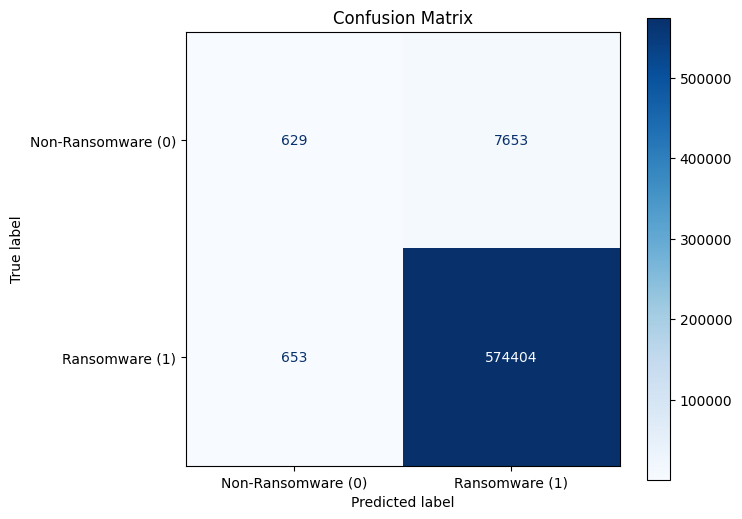


Full Random Forest Confusion Matrix:
                               Predicted Non-Ransomware (False)  Predicted Ransomware (True)
Actual Non-Ransomware (False)                              2691                         5591
Actual Ransomware (True)                                  31783                       543274


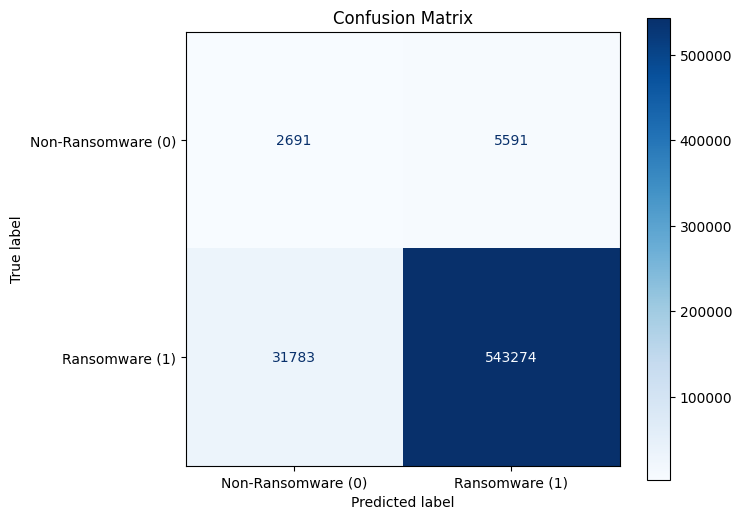


Full Linear SVM Confusion Matrix:
                               Predicted Non-Ransomware (False)  Predicted Ransomware (True)
Actual Non-Ransomware (False)                              6123                         2159
Actual Ransomware (True)                                 279554                       295503


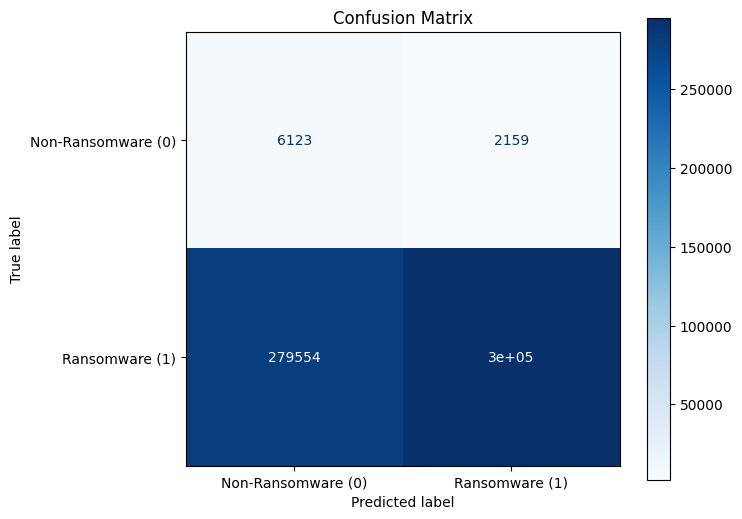

In [ ]:
# 1st Visualization Technique
# For Supervised Models with Full Features

# Confusion Matrix Visualization

print("Full KNN Confusion Matrix:")
confusion_matrix_display(full_KNN, engineered_test_features, engineered_test_target)
print("Full Random Forest Confusion Matrix:")
confusion_matrix_display(full_RF,  engineered_test_features, engineered_test_target)
print("Full Linear SVM Confusion Matrix:")
confusion_matrix_display(full_SVM, engineered_test_features, engineered_test_target)

Reduced KNN Confusion Matrix:
                               Predicted Non-Ransomware (False)  Predicted Ransomware (True)
Actual Non-Ransomware (False)                               397                         7885
Actual Ransomware (True)                                    593                       574464


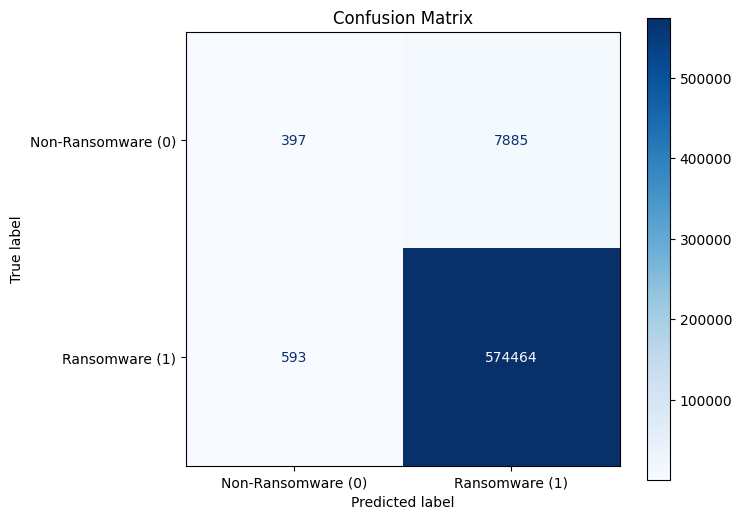


Reduced Random Forest Confusion Matrix:
                               Predicted Non-Ransomware (False)  Predicted Ransomware (True)
Actual Non-Ransomware (False)                              2871                         5411
Actual Ransomware (True)                                  37393                       537664


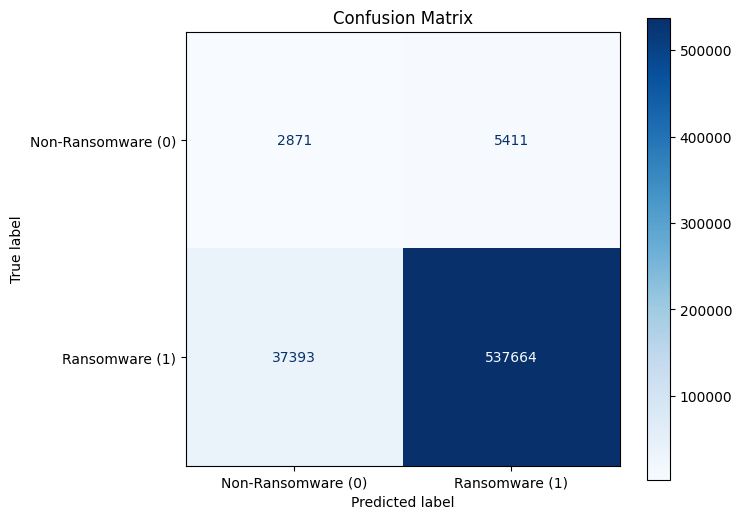


Reduced Linear SVM Confusion Matrix:
                               Predicted Non-Ransomware (False)  Predicted Ransomware (True)
Actual Non-Ransomware (False)                              5386                         2896
Actual Ransomware (True)                                 283937                       291120


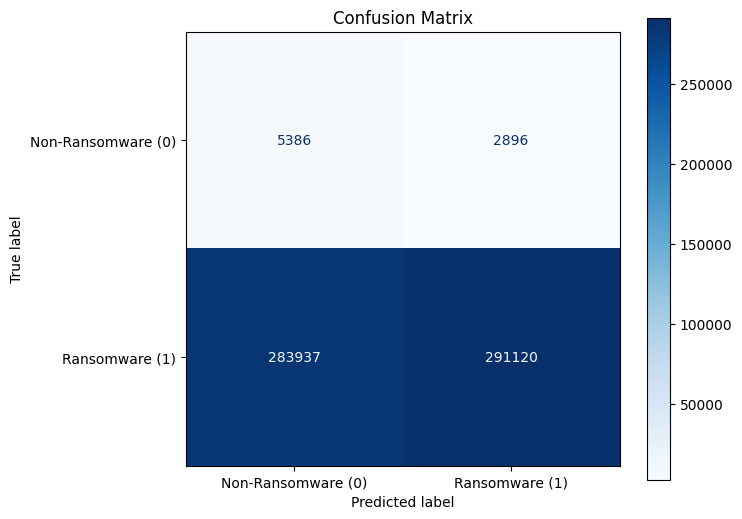

In [ ]:
# 1st Visualization Technique
# For Supervised Models with Reduced Features

# Confusion Matrix Visualization

print("Reduced KNN Confusion Matrix:")
confusion_matrix_display(reduced_KNN, reduced_engineered_test_features, reduced_engineered_test_target)
print("Reduced Random Forest Confusion Matrix:")
confusion_matrix_display(reduced_RF,  reduced_engineered_test_features, reduced_engineered_test_target)
print("Reduced Linear SVM Confusion Matrix:")
confusion_matrix_display(reduced_SVM, reduced_engineered_test_features, reduced_engineered_test_target)

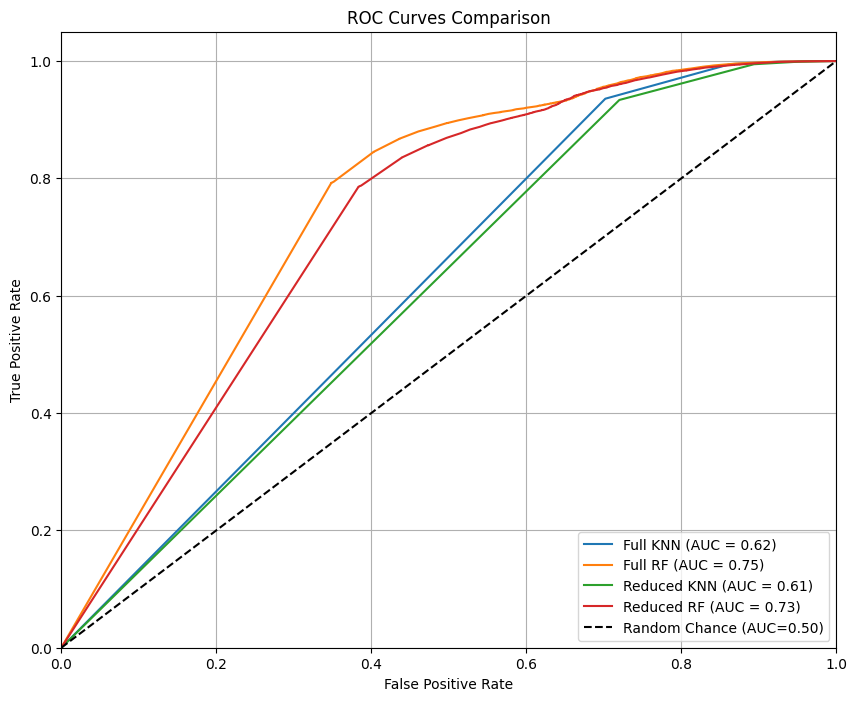

In [ ]:
# 2nd Visualization Technique (ROC Curve)
# For Supervised Models with Full Features

# Make a function that compare all the models with an overlayed ROC curve
from sklearn.metrics import roc_curve, auc

def plot_all_roc(models_dict, x_test_dict, y_test_dict, title="ROC Curves Comparison"):
    plt.figure(figsize=(10, 8))
    for model_name, model in models_dict.items():
        if hasattr(model, "predict_proba"):  # Skip if no predict_proba (e.g., some SVM configs)
            x_test = x_test_dict[model_name.split()[0]]  # 'Full' or 'Reduced'
            y_test = y_test_dict[model_name.split()[0]]

            y_prob = model.predict_proba(x_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC=0.50)')  # Baseline
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Usage: Prepare dicts for your loaded models, features, and targets
models = {
    'Full KNN': full_KNN,
    'Full RF': full_RF,
    'Full SVM': full_SVM,
    'Reduced KNN': reduced_KNN,
    'Reduced RF': reduced_RF,
    'Reduced SVM': reduced_SVM
}

x_test_dict = {'Full': engineered_test_features, 'Reduced': reduced_engineered_test_features}
y_test_dict = {'Full': engineered_test_target, 'Reduced': reduced_engineered_test_target}

plot_all_roc(models, x_test_dict, y_test_dict)

In [ ]:
# 3rd Visualization Technique (PCA Scatter Plot)
# For Supervised Models with Full Features
# Reduces features to 2D via PCA and plots points colored by cluster labels

from sklearn.decomposition import PCA
def plot_kmeans_clusters(features, predictions, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=predictions, palette='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


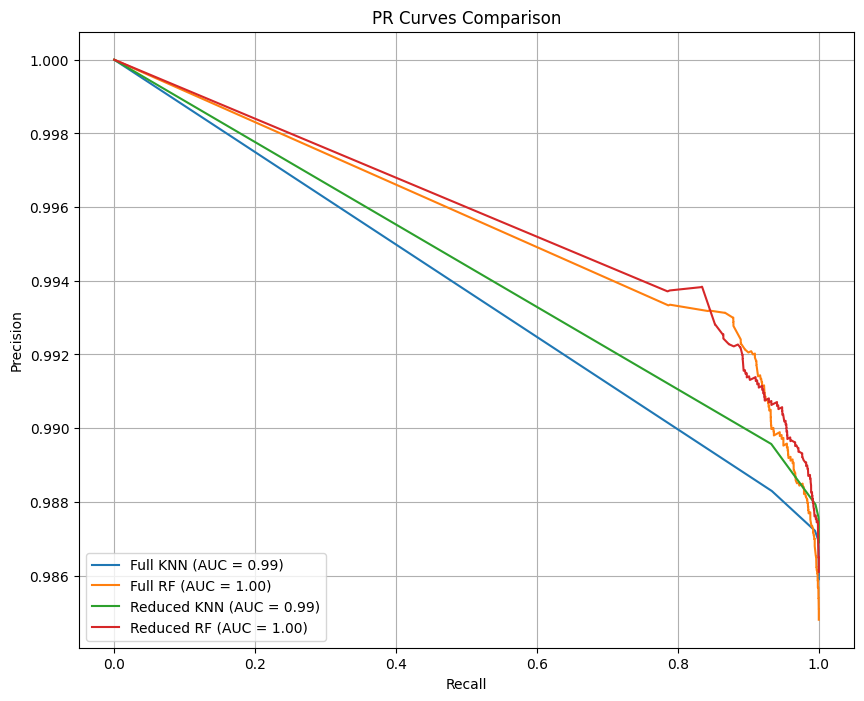

In [ ]:
# 3rd Visualization technique

from sklearn.metrics import precision_recall_curve, auc

def plot_all_pr_curves(models_dict, x_test_dict, y_test_dict, title="PR Curves Comparison"):
    import numpy as np  # Ensure np is available inside the function
    plt.figure(figsize=(10, 8))
    sample_size = 10000  # Adjustable; start here, reduce if still slow

    for model_name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            # Get the correct large test data for this model (Full or Reduced)
            x_test = x_test_dict[model_name.split()[0]]  # This will be engineered_test_features (583339 rows) for 'Full' models
            y_test = y_test_dict[model_name.split()[0]]

            # Sample dynamically (uses the large len(x_test) == 583339)
            current_size = len(x_test)
            effective_sample = min(sample_size, current_size)
            if effective_sample < current_size:
                indices = np.random.choice(current_size, effective_sample, replace=False)
                x_sample = x_test.iloc[indices]
                y_sample = y_test.iloc[indices]
            else:
                x_sample = x_test  # Use full if smaller (won't happen here)
                y_sample = y_test

            y_prob = model.predict_proba(x_sample)[:, 1]
            precision, recall, _ = precision_recall_curve(y_sample, y_prob)
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Use the same dictionary of models as before for a proper overlay of the curve
plot_all_pr_curves(models, x_test, y_test)

In [ ]:
# Predict values for K Means Clustering

full_kmeans_predictions = full_KMEANS.predict(engineered_test_features)
reduced_kmeans_predictions = reduced_KMEANS.predict(reduced_engineered_test_features)

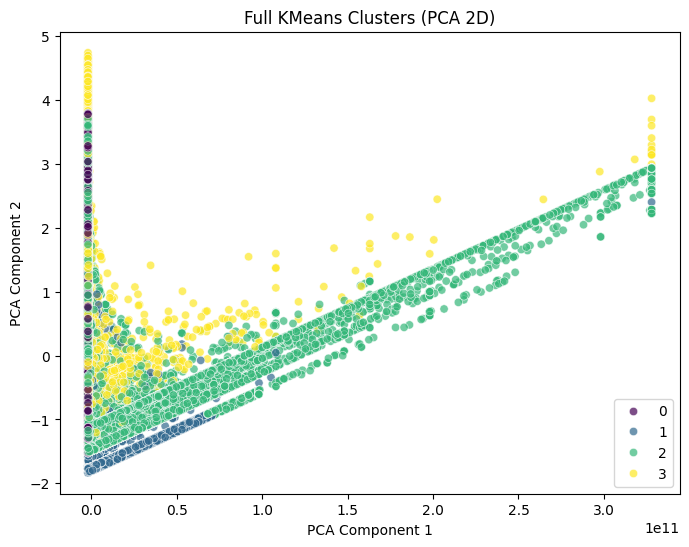

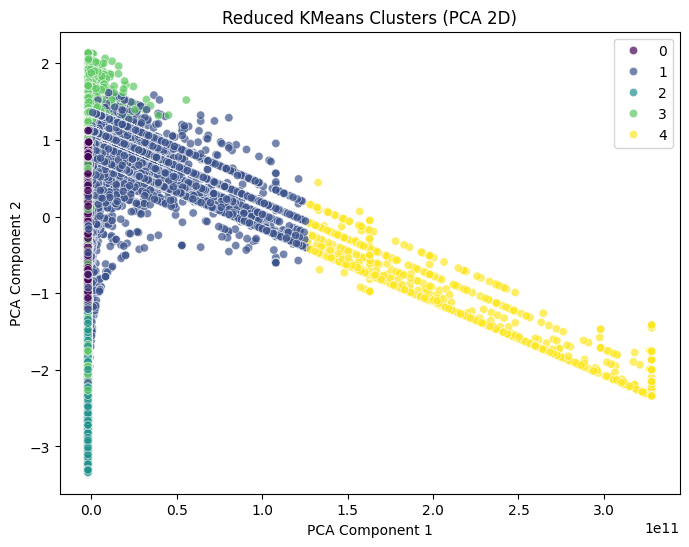

In [ ]:
#--- CONTINUED FROM PREVIOUS CELL---

# 4th Visualization Technique (PCA Scatter Plot)
# For Supervised Models with Full Features
# Reduces features to 2D via PCA and plots points colored by cluster labels

plot_kmeans_clusters(engineered_test_features, full_kmeans_predictions, "Full KMeans Clusters (PCA 2D)")
plot_kmeans_clusters(reduced_engineered_test_features, reduced_kmeans_predictions, "Reduced KMeans Clusters (PCA 2D)")

In [ ]:
# Evaluation metrics for K Means Clustering

In [ ]:
# Silhouette Score Metric for unsupervised K-Means Clustering

from sklearn.metrics import silhouette_score

# Measures how similar samples are within clusters vs. between clusters
 # (range: -1 to +1; higher is better)
# Randomly sample indices (10,000 samples)
sample_size = 10000
indices = np.random.choice(len(engineered_test_features), sample_size, replace=False)

# Compute on subset
full_kmeans_silhouette = silhouette_score(engineered_test_features.iloc[indices], full_kmeans_predictions[indices])
print("Full KMeans Silhouette Score (on sample):", round(full_kmeans_silhouette, 2))

Full KMeans Silhouette Score (on sample): -0.4


In [ ]:
# Adjusted Rand Index (ARI)

from sklearn.metrics import adjusted_rand_score

# External validation metric that measures the similarity between the predicted
# cluster labels and the true ground-truth labels

# For full features
full_ari = adjusted_rand_score(engineered_test_target, full_kmeans_predictions)
print("Full KMeans Adjusted Rand Index:", round(full_ari, 2))

# For reduced features
reduced_ari = adjusted_rand_score(reduced_engineered_test_target, reduced_kmeans_predictions)
print("Reduced KMeans Adjusted Rand Index:", round(reduced_ari, 2))

Full KMeans Adjusted Rand Index: 0.0
Reduced KMeans Adjusted Rand Index: -0.0


An adjusted Rand index of 0.0 is bad, usually implying that the data is very imbalanced. Which it is as specified by the source fo our data. We will need to use a better model more suited for heavily imbalanced data.

After visualizing our different models, Knn, Random Forest, Linear SVM and K means, one model has surpassed in its predictions and it is Random Forest. Using evaluation metrics for the supervised models alone, precision, recall and f1 score are more telling in predicting the smaller class in our data. KNN has high accuracy, but low recall so it does not predict our minority class. Linear SVM has medium accuracy and high recall, so the precision is low and it is overpredicting the minority class. Random Forest has high accuracy and medium recall, meaning it is more accurate than kNN and is more balanced at detecting both classes. The confusion matrixes visually show this.

The ROC curve plots true positive rate vs the false positive rate, which visually helps us see the most balanced model amongst the two classes. Clearly, random forest is still outperforming the other supervised learning models.
